In [1]:
import pandas as pd
from surprise import Dataset as Surprise_Dataset
from surprise import Reader, SVD
from surprise.model_selection import cross_validate

ratings_clean = pd.read_parquet("../data/processed/ratings_clean.parquet")

# SVD

In [2]:
# Surprise 라이브러리 데이터 형식으로 변환
# 평점(rating)의 범위를 지정. MovieLens는 0.5~5.0
reader = Reader(rating_scale=(0.5, 5.0))
data = Surprise_Dataset.load_from_df(
    ratings_clean[["userId", "movieId", "rating"]], reader
)

In [3]:
# SVD 모델 정의 및 교차 검증
svd = SVD(verbose=True)
cv_results = cross_validate(svd, data, measures=["RMSE", "MAE"], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing

In [4]:
print("\nSVD Cross-Validation Results:")
print(cv_results)


SVD Cross-Validation Results:
{'test_rmse': array([0.90211991, 0.89616806, 0.88587305]), 'test_mae': array([0.69045029, 0.68619662, 0.68098762]), 'fit_time': (0.516387939453125, 0.44516658782958984, 0.5139446258544922), 'test_time': (0.10825991630554199, 0.09551620483398438, 0.18036866188049316)}


# NCF

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# 모델이 사용할 수 있도록 ID를 0부터 시작하는 연속된 값으로 매핑핑
user_map = {id: i for i, id in enumerate(ratings_clean["userId"].unique())}
movie_map = {id: i for i, id in enumerate(ratings_clean["movieId"].unique())}

ratings_clean["user_idx"] = ratings_clean["userId"].map(user_map)
ratings_clean["movie_idx"] = ratings_clean["movieId"].map(movie_map)

In [6]:
train_df, val_df = train_test_split(ratings_clean, test_size=0.2, random_state=42)

In [7]:
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df["user_idx"].values, dtype=torch.long)
        self.movies = torch.tensor(df["movie_idx"].values, dtype=torch.long)
        self.ratings = torch.tensor(df["rating"].values, dtype=torch.float32)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

In [8]:
train_dataset = RatingsDataset(train_df)
val_dataset = RatingsDataset(val_df)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024)

In [10]:
import torch.nn as nn


class NCF(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim=32):
        super().__init__()
        # User, Movie Index로 진행 => 특성을 매핑할 Embedding Vector
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, user_indices, movie_indices):
        user_embed = self.user_embedding(user_indices)
        movie_embed = self.movie_embedding(movie_indices)
        x = torch.cat([user_embed, movie_embed], dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x.squeeze()

In [20]:
num_users = len(user_map)
num_movies = len(movie_map)
ncf_model = NCF(num_users, num_movies)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ncf_model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ncf_model.parameters(), lr=0.001)

In [22]:
train_losses = []
val_losses = []

for epoch in range(10):
    ncf_model.train()
    running_train_loss = 0.0

    # ===== TRAIN =====
    for users, movies, ratings in train_loader:
        users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
        optimizer.zero_grad()
        outputs = ncf_model(users, movies)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ===== VALIDATION =====
    ncf_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for users, movies, ratings in val_loader:
            users, movies, ratings = (
                users.to(device),
                movies.to(device),
                ratings.to(device),
            )
            outputs = ncf_model(users, movies)
            outputs = torch.clamp(outputs, 0.5, 5)
            loss = criterion(outputs, ratings)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(
        f"Epoch {epoch+1}, Train Loss(MSE): {avg_train_loss:.4f}, Val Loss(MSE): {avg_val_loss:.4f}"
    )

Epoch 1, Train Loss(MSE): 4.1119, Val Loss(MSE): 1.1512
Epoch 2, Train Loss(MSE): 1.0782, Val Loss(MSE): 1.0206
Epoch 3, Train Loss(MSE): 0.9860, Val Loss(MSE): 0.9614
Epoch 4, Train Loss(MSE): 0.9274, Val Loss(MSE): 0.9251
Epoch 5, Train Loss(MSE): 0.8856, Val Loss(MSE): 0.8973
Epoch 6, Train Loss(MSE): 0.8553, Val Loss(MSE): 0.8777
Epoch 7, Train Loss(MSE): 0.8307, Val Loss(MSE): 0.8646
Epoch 8, Train Loss(MSE): 0.8113, Val Loss(MSE): 0.8545
Epoch 9, Train Loss(MSE): 0.7947, Val Loss(MSE): 0.8440
Epoch 10, Train Loss(MSE): 0.7776, Val Loss(MSE): 0.8373


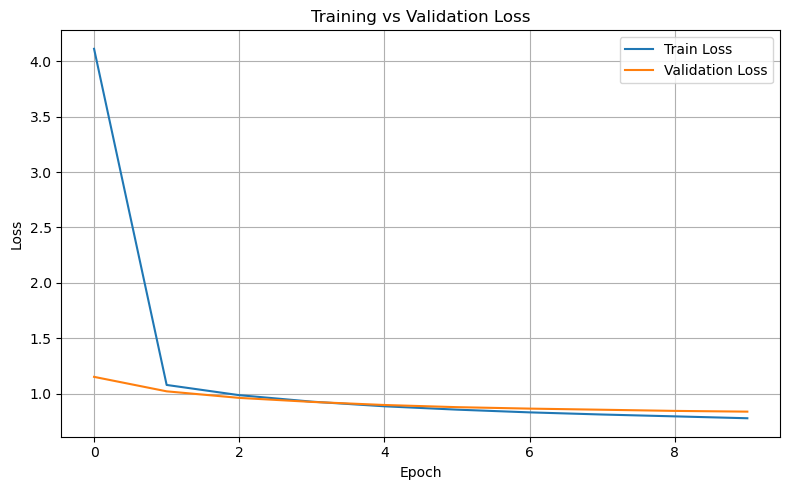

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()